## Utils by PiotrCzapla
https://github.com/PiotrCzapla/course22p2/blob/main/nbs/12_utils.ipynb

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder


from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *

from miniai.init import *

In [ ]:
from torcheval.metrics import Metric, Mean

class LazyMean(Mean):
    def __init__(self): 
        super().__init__()
        self.buffer = []
        
    def reset(self):
        super().reset()
        self.buffer = []
    
    def to(self, device): pass # ignore we compute on cpu

    def update(self, val, weight=tensor(1.0)): self.buffer.append((val.detach(), tensor(weight).detach().float()))

    def compute(self):
        for val,w in self.buffer: super().update(val.to('cpu'), weight=w.to('cpu'))
        self.buffer = []    
        return super().compute() 

In [ ]:
MetricsCB??

In [ ]:
from copy import copy
from miniai.learner import Mean, master_bar, progress_bar

class LazyMetricsCB(Callback):
    order = MetricsCB.order
    def __init__(self, *ms, device=def_device, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        #self.all_metrics['loss'] = self.loss = LazyMean() if torch.backends.mps.is_available() else Mean()
        ##FM
        self.all_metrics['loss'] = self.loss = Mean()
        self.device = def_device    # Added by Piotr
                

    def _log(self, d): print(d)
    def before_fit(self, learn): 
        learn.metrics = self 
        # Added by Piotr
        self.device = [*(cb.device for cb in learn.cbs if isinstance(cb, DeviceCB)), self.device][0]
                
    def before_epoch(self, learn): 
        for o in self.all_metrics.values(): 
            o.reset()
            o.to(self.device)
    
    @torch.no_grad()
    def after_epoch(self, learn):
        log = {k:f'{to_cpu(v.compute()):.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)
    
    @torch.no_grad()
    def after_batch(self, learn):
        x,y,*_ = learn.batch
        for m in self.metrics.values(): m.update(learn.preds, y)
        self.loss.update(learn.loss, weight=len(x))

In [ ]:
class LazyProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): 
        self.plot = plot
        self.count = 0
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.dev_losses = []
        self.losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)
        if self.plot:
            for l in self.dev_losses: self.losses.append(to_cpu(l))
            self.dev_losses=[]
            #print(self.losses[:10])
            self.mbar.update_graph([[fc.L.range(self.losses), self.losses]])
        
    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        #learn.dl.comment = f'{learn.loss:.3f}' # not sure how it is being used
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.dev_losses.append(learn.loss.detach())

In [ ]:
import time

def _format_stats(stats):
    return f"{stats.mean():.2f} ± {stats.std():.2f}"

class TimeItCB(Callback):
    def __init__(self): self.reset()
    def tick(self): return time.time()
         
    def reset(self):
        self.start = self.tick()
        self.setup = None
        self.batches = {True:[], False:[]}
        self.epochs = {True:[], False:[]}
        self.samples = {True:[], False:[]}
        
    def before_fit(self, learn): self.reset()
        
    def before_batch(self, learn):
        if self.setup is None: self.setup = self.tick() - self.start
        self.batches[learn.training].append(self.tick())
    
    def after_batch(self, learn):
        self.batches[learn.training][-1] = self.tick() - self.batches[learn.training][-1]
        self.samples[learn.training].append(learn.batch[0].shape[0])
    
    def before_epoch(self, learn):
        
        self.epochs[learn.training].append(self.tick())
        #print(f"Before {self.epochs[learn.training]=}")
    
    def after_epoch(self, learn):
        
        self.epochs[learn.training][-1] = self.tick() - self.epochs[learn.training][-1]
        #print(f"After {self.epochs[learn.training]=}")
    
    def after_fit(self, learn):
        #print(f"{self.epochs[learn.training]=}")
        self.total = self.tick() - self.start
        self.setup = self.setup / self.total
        self.batches = {k:np.array(v) for k,v in self.batches.items()}
        self.epochs = {k:np.array(v) for k,v in self.epochs.items()}
        self.samples = {k:np.array(v) for k,v in self.samples.items()}
        self.print_stats()
    
    def print_stats(self): 
        print(f"Fit {len(self.epochs[True])} in: {self.total:.2f}s, setup: {self.setup:.2f}s, {_format_stats(self.epochs[True])}s per epoch, {_format_stats(self.batches[True])}s per batch")

6

In [ ]:
## FM simplifued

import time

def _format_stats(stats):
    return f"{stats.mean():.2f} ± {stats.std():.2f}"

class TimeItCBFM(Callback):
    def __init__(self): self.reset()
    def tick(self): return time.time()
         
    def reset(self):
        self.start = self.tick()
        self.batches = {True:[], False:[]}
        self.epochs = {True:[], False:[]}
        
    def before_fit(self, learn): self.reset()
        
    def before_batch(self, learn):
        self.batches[learn.training].append(self.tick())
    
    def after_batch(self, learn):
        self.batches[learn.training][-1] = self.tick() - self.batches[learn.training][-1]
    
    def before_epoch(self, learn):
        self.epochs[learn.training].append(self.tick())
    
    def after_epoch(self, learn):
        self.epochs[learn.training][-1] = self.tick() - self.epochs[learn.training][-1]
    
    def after_fit(self, learn):
        self.total = self.tick() - self.start
        self.batches = {k:np.array(v) for k,v in self.batches.items()}
        self.epochs = {k:np.array(v) for k,v in self.epochs.items()}
        self.print_stats()
    
    def print_stats(self): 
        print(f"Fit {len(self.epochs[True])} in: {self.total:.2f}s, setup: {self.setup:.2f}s, {_format_stats(self.epochs[True])}s per epoch, {_format_stats(self.batches[True])}s per batch")

In [ ]:
# if spawn is not possible, we can cache the entire dataset in memory after transformations
def _with_features(ds):
    setattr((l:=fc.L(ds)), 'features', ds.features)
    return l 
def cache_dataset_as_dict(dd): return {dsn: _with_features(ds) for dsn,ds in dd.items()}

In [ ]:
lazy_cbs = [DeviceCB(), LazyMetricsCB(accuracy=MulticlassAccuracy()), LazyProgressCB(plot=True), TimeItCB()]
#eager_cbs = [DeviceCB(), LazyMetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(plot=True), TimeItCB()]

##FM
eager_cbs = [DeviceCB(), MetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(plot=True), TimeItCB()]

In [ ]:
bs = 1024
xmean, xstd = 0.28, 0.35
name = "fashion_mnist"
def to_tensor_tfm(b, mean, std, xl='image'): 
    b[xl] = [(TF.to_tensor(o)-mean)/std for o in b[xl]]
    return b

dsd = load_dataset(name)
tds = dsd.with_transform(partial(to_tensor_tfm, mean=xmean, std=xstd))

Found cached dataset fashion_mnist (/home/fmussari/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
a=b=dict(True:[], False:[])
a,b

SyntaxError: invalid syntax (1399497189.py, line 1)

In [ ]:
def test_speed(cbs, dls):
    set_seed(42)
    learn = TrainLearner(get_model().to('cpu').apply(init_weights), dls, 
                         F.cross_entropy, lr=1e-2, cbs=cbs, opt_func=optim.AdamW)
    learn.fit(2)

accuracy,loss,epoch,train
0.766,0.669,0,train
0.835,0.451,0,eval
0.862,0.380,1,train
0.852,0.396,1,eval


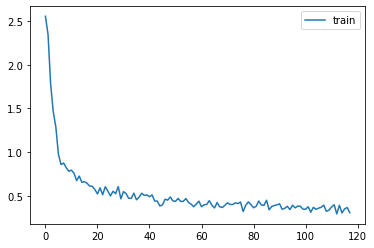

Fit 2 in: 139.72s, setup: 0.01s, 62.66 ± 5.16s per epoch, 0.08 ± 0.60s per batch


In [ ]:
test_speed(eager_cbs, dls=DataLoaders.from_dd(tds, bs, num_workers=4, ))

accuracy,loss,epoch,train
0.766,0.669,0,train
0.836,0.448,0,eval
0.861,0.382,1,train
0.853,0.399,1,eval


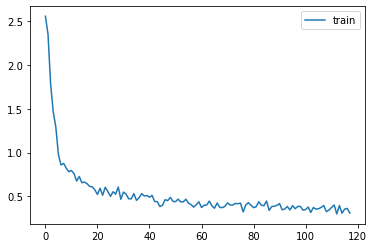

Fit 2 in: 99.16s, setup: 0.01s, 42.35 ± 0.12s per epoch, 0.01 ± 0.00s per batch


In [ ]:
test_speed(lazy_cbs, dls=DataLoaders.from_dd(tds, bs, num_workers=4, ))

In [ ]:
%%timeit -n 1 -r 1
tds.cached = cache_dataset_as_dict(tds)

43.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


accuracy,loss,epoch,train
0.766,0.669,0,train
0.835,0.451,0,eval
0.862,0.381,1,train
0.850,0.400,1,eval


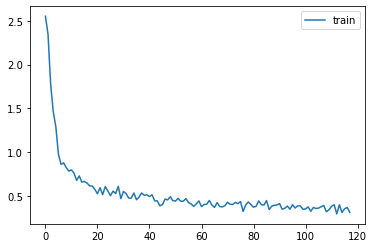

Fit 2 in: 36.83s, setup: 0.00s, 18.12 ± 0.89s per epoch, 0.03 ± 0.00s per batch


In [ ]:
test_speed(eager_cbs, dls=DataLoaders.from_dd(tds.cached, bs, num_workers=0, ))

accuracy,loss,epoch,train
0.765,0.669,0,train
0.833,0.453,0,eval
0.863,0.379,1,train
0.850,0.396,1,eval


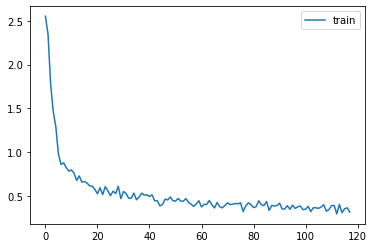

Fit 2 in: 4.05s, setup: 0.01s, 1.57 ± 0.11s per epoch, 0.01 ± 0.00s per batch


In [ ]:
test_speed(lazy_cbs, dls=DataLoaders.from_dd(tds.cached, bs, num_workers=0, ))

In [ ]:
def test_speed(cbs, dls):
    set_seed(42)
    learn = TrainLearner(get_model().to('cpu').apply(init_weights), dls, 
                         F.cross_entropy, lr=1e-2, cbs=cbs, opt_func=optim.AdamW)
    learn.fit(5)

def_device='cuda'


accuracy,loss,epoch,train
0.766,0.669,0,train
0.834,0.452,0,eval
0.862,0.381,1,train
0.846,0.408,1,eval
0.880,0.328,2,train
0.875,0.351,2,eval
0.891,0.294,3,train
0.872,0.345,3,eval
0.897,0.275,4,train
0.882,0.326,4,eval


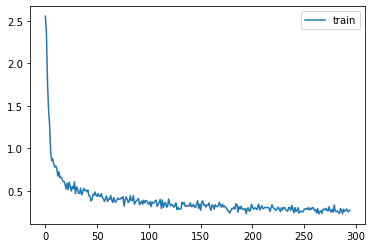

Fit 5 in: 8.76s, setup: 0.00s, 1.37 ± 0.08s per epoch, 0.01 ± 0.00s per batch


In [ ]:
lazy_cbs = [DeviceCB(), LazyMetricsCB(accuracy=MulticlassAccuracy()), LazyProgressCB(plot=True), TimeItCB()]
test_speed(lazy_cbs, dls=DataLoaders.from_dd(tds.cached, bs, num_workers=0, ))

In [ ]:
_cbs = [DeviceCB(), LazyMetricsCB(accuracy=MulticlassAccuracy()), TimeItCB()]
test_speed(_cbs, dls=DataLoaders.from_dd(tds.cached, bs, num_workers=0, ))

def_device='cuda'
Before self.epochs[learn.training]=[1676983679.4958346]
{'accuracy': '0.766', 'loss': '0.669', 'epoch': 0, 'train': 'train'}
After self.epochs[learn.training]=[1.0893940925598145]
Before self.epochs[learn.training]=[1676983680.5879033]
{'accuracy': '0.836', 'loss': '0.450', 'epoch': 0, 'train': 'eval'}
After self.epochs[learn.training]=[0.08417010307312012]
Before self.epochs[learn.training]=[1.0893940925598145, 1676983680.67332]
{'accuracy': '0.861', 'loss': '0.382', 'epoch': 1, 'train': 'train'}
After self.epochs[learn.training]=[1.0893940925598145, 1.0076909065246582]
Before self.epochs[learn.training]=[0.08417010307312012, 1676983681.682539]
{'accuracy': '0.850', 'loss': '0.403', 'epoch': 1, 'train': 'eval'}
After self.epochs[learn.training]=[0.08417010307312012, 0.07034564018249512]
Before self.epochs[learn.training]=[1.0893940925598145, 1.0076909065246582, 1676983681.7542882]
{'accuracy': '0.880', 'loss': '0.329', 'epoch': 2, 'train': 'train'}
After self.epochs[